<a href="https://colab.research.google.com/github/anshudaur/TensorFlowProjects/blob/master/Convolution_model_Application_OxfordFlowerDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#for resnet
#!pip install tensorflow-probability==0.8.0rc0

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)
import pathlib
import matplotlib.pyplot as plt


TensorFlow 2.x selected.
2.1.0-rc1


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/CVDL_Project/dataset/'  #change dir to your project folder

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data_dir=pathlib.Path(root_path+'train')
valid_dir=pathlib.Path(root_path+'valid')
test_dir=pathlib.Path(root_path+'test')
print(data_dir,',',valid_dir,',',test_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
valid_image_count = len(list(valid_dir.glob('*/*.jpg')))
print(valid_image_count)

gdrive/My Drive/CVDL_Project/dataset/train , gdrive/My Drive/CVDL_Project/dataset/valid , gdrive/My Drive/CVDL_Project/dataset/test
4918
1638


In [0]:
import numpy as np

from numpy.random import seed
seed(1)
tf.random.set_seed(2)

BATCH_SIZE = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
print(CLASS_NAMES)

['98' '99' '93' '97' '96' '94' '90' '95' '92' '91' '9' '89' '85' '82' '83'
 '84' '88' '86' '87' '81' '8' '80' '79' '78' '71' '72' '75' '74' '76' '73'
 '70' '77' '69' '7' '67' '68' '62' '61' '64' '63' '65' '60' '66' '6' '59'
 '58' '57' '56' '51' '49' '53' '54' '55' '52' '5' '50' '47' '48' '45' '40'
 '44' '41' '4' '43' '42' '46' '39' '38' '37' '36' '34' '31' '3' '35' '29'
 '32' '30' '33' '28' '27' '26' '25' '22' '18' '23' '21' '20' '24' '2' '19'
 '16' '17' '14' '15' '12' '11' '100' '102' '101' '1' '13' '10']


In [0]:
FLOWER_CLASS_NAMES = {'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', 
                      '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', 
                      '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger',
                      '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', 
                      '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle',
                      '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris',
                      '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan',
                      '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea',
                      '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid',
                      '54': 'sunflower', '66': 'osteospermum', '70': 'tree poppy', '85': 'desert-rose', '99': 'bromelia', '87': 'magnolia', 
                      '5': 'english marigold', '92': 'bee balm', '28': 'stemless gentian', '97': 'mallow', '57': 'gaura', '40': 'lenten rose',
                      '47': 'marigold', '59': 'orange dahlia', '48': 'buttercup', '55': 'pelargonium', '36': 'ruby-lipped cattleya', 
                      '91': 'hippeastrum', '29': 'artichoke', '71': 'gazania', '90': 'canna lily', '18': 'peruvian lily', '98': 'mexican petunia',
                      '8': 'bird of paradise', '30': 'sweet william', '17': 'purple coneflower', '52': 'wild pansy', '84': 'columbine',
                      '12': "colt's foot", '11': 'snapdragon', '96': 'camellia', '23': 'fritillary', '50': 'common dandelion', '44': 'poinsettia', 
                      '53': 'primula', '72': 'azalea', '65': 'californian poppy', '80': 'anthurium', '76': 'morning glory', '37': 'cape flower',
                      '56': 'bishop of llandaff', '60': 'pink-yellow dahlia', '82': 'clematis', '58': 'geranium', '75': 'thorn apple',
                      '41': 'barbeton daisy', '95': 'bougainvillea', '43': 'sword lily', '83': 'hibiscus', '78': 'lotus lotus', '88': 'cyclamen', 
                      '94': 'foxglove', '81': 'frangipani', '74': 'rose', '89': 'watercress', '73': 'water lily', '46': 'wallflower', 
                      '77': 'passion flower', '51': 'petunia'}

In [0]:
 BATCH_SIZE = 64
 image_generator = tf.keras.preprocessing.image.ImageDataGenerator( rescale=1./255, rotation_range=10,width_shift_range=0.2,
                                                                   height_shift_range=0.1,shear_range=0.15,zoom_range=0.1,
                                                                   channel_shift_range=10,horizontal_flip=True)

 train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=True,save_to_dir=root_path,save_prefix='aug',save_format='jpeg',
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      classes = list(CLASS_NAMES),class_mode='categorical',seed=1)
valid_data_gen = image_generator.flow_from_directory(directory=str(valid_dir),
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=True,save_to_dir=root_path,save_prefix='aug',save_format='jpeg',
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      classes = list(CLASS_NAMES),class_mode='categorical',seed=1)
test_data_gen = image_generator.flow_from_directory(directory=str(test_dir),
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=True,save_to_dir=root_path,save_prefix='aug',save_format='jpeg',
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      classes = list(CLASS_NAMES),class_mode='categorical',seed=1)

Found 4918 images belonging to 102 classes.
Found 1638 images belonging to 102 classes.
Found 1638 images belonging to 102 classes.


In [0]:
image_count = len(list(root_path.glob('*/*.jpg')))
print(image_count)

AttributeError: ignored

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

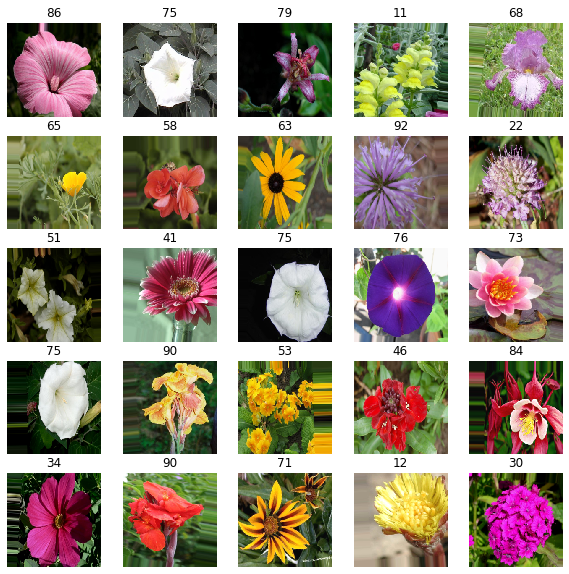

In [0]:
 image_batch, label_batch = next(train_data_gen)
 show_batch(image_batch, label_batch)

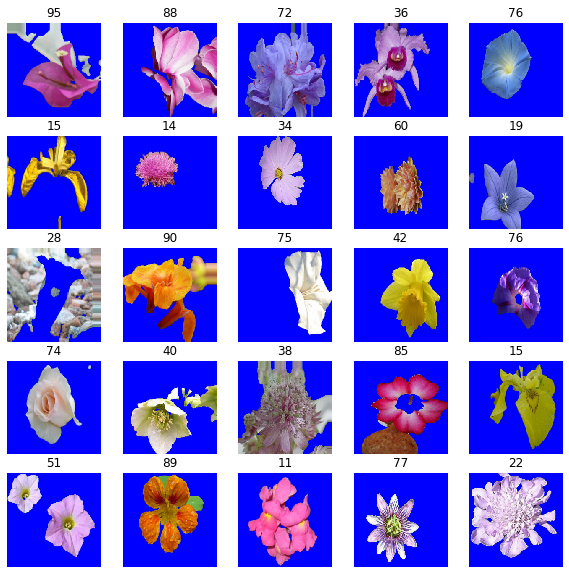

In [0]:
 image_batch, label_batch = next(train_data_gen)
 show_batch(image_batch, label_batch)

In [0]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation

img_shape = (224, 224, 3)

def plotLosses(history):  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def plotAccuracies(history):  
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='upper right')
    plt.show()



In [0]:
import time
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
#from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import optimizers
#from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.callbacks import EarlyStopping

def run_model(model,model_name):
  start = time.time()
  sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
  model.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])
  model.summary()
  history=model.fit(train_data_gen,
                      epochs=100,
                      validation_data=valid_data_gen)
  print('\nhistory dict:', history.history)

  plotLosses(history)
  plotAccuracies(history)
  end = time.time()
  print('Processing time:',(end - start)/60)
  model.save(root_path+model_name+'.h5')

small cnn : Accuracy on test data 53%

In [0]:

model_cnn = tf.keras.Sequential()
model_cnn.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3),kernel_initializer='he_normal'))
model_cnn.add(layers.Conv2D(32, (3,3), activation='relu',kernel_initializer='he_normal'))
model_cnn.add(layers.MaxPooling2D(pool_size=2, strides=2))
model_cnn.add(layers.Conv2D(64, (3,3), activation='relu',kernel_initializer='he_normal'))
model_cnn.add(layers.Conv2D(64, (3,3), activation='relu',kernel_initializer='he_normal'))
model_cnn.add(layers.MaxPooling2D(pool_size=2, strides=2))
model_cnn.add(layers.Conv2D(128, (3,3), activation='relu',kernel_initializer='he_normal'))
model_cnn.add(layers.Conv2D(128, (3,3), activation='relu',kernel_initializer='he_normal'))
model_cnn.add(layers.MaxPooling2D(pool_size=2, strides=2))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(128,kernel_initializer='he_normal', activation='relu'))
model_cnn.add(layers.Dense(102 ,activation='softmax'))
run_model(model_cnn,'small_cnn_4layers_3rdRun')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 106, 106, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 51, 51, 128)      

In [0]:
#small_cnn_4layers_2ndRun
scores = model_cnn.evaluate_generator(test_data_gen) 
print("Accuracy = ", scores[1])

Accuracy =  0.53235656


In [0]:
#small_cnn_4layers_3rdRun
scores = model_cnn.evaluate_generator(test_data_gen) 
print("Accuracy = ", scores[1])

In [0]:
print(scores)

[2.1043994289178114, 0.53235656]


small cnn with kernel_initializer for all conv layers : 56.5% test accuracy 

* he_normal initializer for relu activation function




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 109, 109, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 107, 107, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 105, 105, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 52, 52, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 128)       7

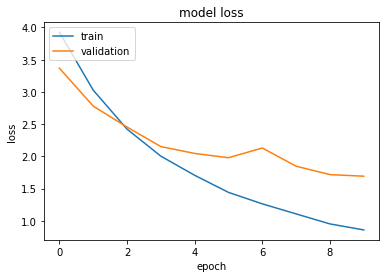

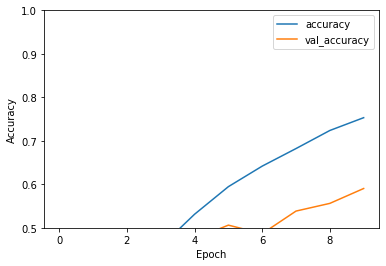

Processing time: 43.90438601175944
Loss =  1.7557234305601854 , Accuracy =  0.56593406


In [0]:

model_cnn = tf.keras.Sequential()
model_cnn.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3),kernel_initializer='he_normal'))
model_cnn.add(layers.Conv2D(32, (3,3), activation='relu',kernel_initializer='he_normal'))
model_cnn.add(layers.MaxPooling2D(pool_size=3, strides=2))
model_cnn.add(layers.Conv2D(64, (3,3), activation='relu',kernel_initializer='he_normal'))
model_cnn.add(layers.Conv2D(64, (3,3), activation='relu',kernel_initializer='he_normal'))
model_cnn.add(layers.MaxPooling2D(pool_size=2, strides=2))
model_cnn.add(layers.Conv2D(128, (3,3), activation='relu',kernel_initializer='he_normal'))
model_cnn.add(layers.Conv2D(128, (3,3), activation='relu',kernel_initializer='he_normal'))
model_cnn.add(layers.MaxPooling2D(pool_size=2, strides=2))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(128,kernel_initializer='he_normal', activation='relu'))
model_cnn.add(layers.Dense(102,activation='softmax'))
run_model(model_cnn,'small_cnn_4layers_HenormInit')

scores = model_cnn.evaluate_generator(test_data_gen) 
print("Loss = ",scores[0],", Accuracy = ", scores[1])



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 109, 109, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 107, 107, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 105, 105, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 52, 52, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 128)       7

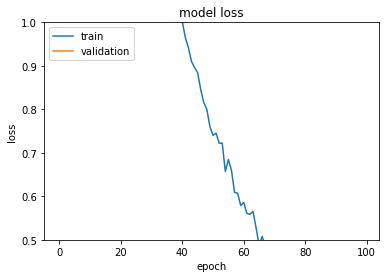

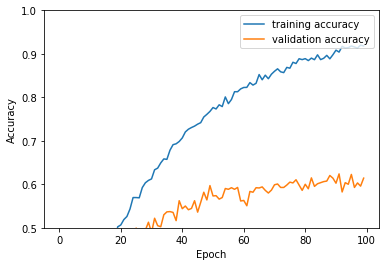

Processing time: 198.46910422643026
  ...
    to  
  ['...']
26/26 [==============================] - 417s 16s/step - loss: 2.2440 - accuracy: 0.6123
Loss =  2.243957670835348 , Accuracy =  0.6123321


In [0]:

model_cnn = tf.keras.Sequential()
model_cnn.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3),kernel_initializer='he_normal'))
model_cnn.add(layers.Conv2D(32, (3,3), activation='relu',kernel_initializer='he_normal'))
model_cnn.add(layers.MaxPooling2D(pool_size=3, strides=2))
model_cnn.add(layers.Conv2D(64, (3,3), activation='relu',kernel_initializer='he_normal'))
model_cnn.add(layers.Conv2D(64, (3,3), activation='relu',kernel_initializer='he_normal'))
model_cnn.add(layers.MaxPooling2D(pool_size=2, strides=2))
model_cnn.add(layers.Conv2D(128, (3,3), activation='relu',kernel_initializer='he_normal'))
model_cnn.add(layers.Conv2D(128, (3,3), activation='relu',kernel_initializer='he_normal'))
model_cnn.add(layers.MaxPooling2D(pool_size=2, strides=2))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(128,kernel_initializer='he_normal', activation='relu'))
model_cnn.add(layers.Dense(128,kernel_initializer='he_normal', activation='relu'))
model_cnn.add(layers.Dense(102,activation='softmax'))
run_model(model_cnn,'small_cnn_6layers_HenormInit')

scores = model_cnn.evaluate(test_data_gen) 
print("Loss = ",scores[0],", Accuracy = ", scores[1])

 #plotLosses(history)
  #plotAccuracies(history)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 109, 109, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 107, 107, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 105, 105, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 52, 52, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 128)      

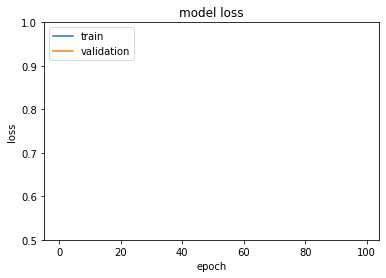

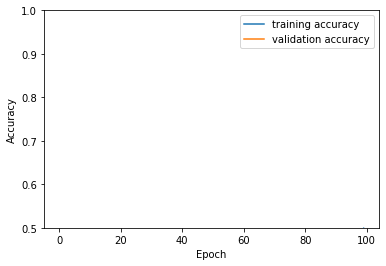

Processing time: 169.42923144896824
  ...
    to  
  ['...']
26/26 [==============================] - 24s 927ms/step - loss: 3.0621 - accuracy: 0.4139
Loss =  3.0621077555876512 , Accuracy =  0.41391942


In [0]:
from tensorflow.keras import regularizers

model_cnn = tf.keras.Sequential()
model_cnn.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3),kernel_regularizer=regularizers.l2(0.01)))
model_cnn.add(layers.Conv2D(32, (3,3), activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model_cnn.add(layers.MaxPooling2D(pool_size=3, strides=2))
model_cnn.add(layers.Conv2D(64, (3,3), activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model_cnn.add(layers.Conv2D(64, (3,3), activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model_cnn.add(layers.MaxPooling2D(pool_size=2, strides=2))
model_cnn.add(layers.Conv2D(128, (3,3), activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model_cnn.add(layers.Conv2D(128, (3,3), activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model_cnn.add(layers.MaxPooling2D(pool_size=2, strides=2))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(128,kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model_cnn.add(layers.Dense(128,kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model_cnn.add(layers.Dense(102,activation='softmax'))
run_model(model_cnn,'model_cnn_6layers_L2reg')

scores = model_cnn.evaluate(test_data_gen) 
print("Loss = ",scores[0],", Accuracy = ", scores[1])

 #plotLosses(history)
  #plotAccuracies(history)

In [0]:
# import keras
import tensorflow as tf
# from tf.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
# from tensorflow.keras.layers.normalization import BatchNormalization
import numpy as np
#Instantiate an empty model
model = tf.keras.Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=64,input_shape=(224,224,3), kernel_size=(3,3),kernel_initializer='he_uniform' , padding='same', ))
model.add(Activation('relu'))
#2
model.add(Conv2D(filters=64, kernel_size=(3,3),kernel_initializer='he_uniform', padding='same'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))



#3
model.add(Conv2D(filters=128, kernel_size=(3,3),kernel_initializer='he_uniform', padding='same'))
model.add(Activation('relu'))
#4
model.add(Conv2D(filters=128, kernel_size=(3,3),kernel_initializer='he_uniform', padding='same'))
model.add(Activation('relu'))

# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3),kernel_initializer='he_uniform', padding='same'))
model.add(Activation('relu'))
#6
model.add(Conv2D(filters=256, kernel_size=(3,3),kernel_initializer='he_uniform', padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))


# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
# Add Dropout to prevent overfitting

# Output Layer
model.add(Dense(102))
model.add(Activation('softmax'))

model.summary()

sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
activation_2 (Activation)    (None, 112, 112, 128)     0

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 77 steps, validate for 26 steps
Epoch 1/100
77/77 [==============================] - 1911s 25s/step - loss: 4.4799 - accuracy: 0.0476 - val_loss: 4.2495 - val_accuracy: 0.0726
Epoch 2/100
77/77 [==============================] - 119s 2s/step - loss: 4.1859 - accuracy: 0.0712 - val_loss: 3.9637 - val_accuracy: 0.1215
Epoch 3/100
77/77 [==============================] - 118s 2s/step - loss: 3.9580 - accuracy: 0.0984 - val_loss: 3.6801 - val_accuracy: 0.1618
Epoch 4/100
77/77 [==============================] - 118s 2s/step - loss: 3.6973 - accuracy: 0.1423 - val_loss: 3.4577 - val_accuracy: 0.2100
Epoch 5/100
77/77 [==============================] - 118s 2s/step - loss: 3.5027 - accuracy: 0.1698 - val_loss: 3.2927 - val_accuracy: 0.2332
Epoch 6/100
77/77 [==============================] - 117s 2s/step - loss: 3.3186 - accuracy: 0.1980 - val_loss: 3.0650 - val_accuracy: 0.2747
Epoch 7/100
77/77 [==============================] - 1

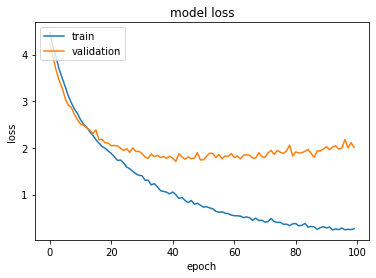

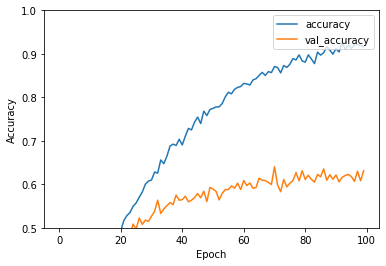

In [0]:
history=model.fit(train_data_gen,validation_data=valid_data_gen,epochs=100)
plotLosses(history)
plotAccuracies(history)
model.save('final_model.h5')

In [0]:
import keras
from matplotlib import pyplot as plt

# history = model1.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(model.history['acc'])
plt.plot(model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

61.9 % on actual dataset

In [0]:
#model.save(root_path+'final_model.h5')
scores = model.evaluate_generator(test_data_gen) 
print("Loss = ",scores[0],", Accuracy = ", scores[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
Loss =  2.1079302109204807 , Accuracy =  0.6098901


 ... % on segmented dataset

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 77 steps, validate for 26 steps
Epoch 1/100
77/77 [==============================] - 2403s 31s/step - loss: 4.5692 - accuracy: 0.0318 - val_loss: 4.3647 - val_accuracy: 0.0446
Epoch 2/100
77/77 [==============================] - 55s 713ms/step - loss: 4.2717 - accuracy: 0.0672 - val_loss: 4.1024 - val_accuracy: 0.0800
Epoch 3/100
77/77 [==============================] - 56s 729ms/step - loss: 3.9697 - accuracy: 0.1065 - val_loss: 3.8485 - val_accuracy: 0.1160
Epoch 4/100
77/77 [==============================] - 56s 722ms/step - loss: 3.7269 - accuracy: 0.1478 - val_loss: 3.5938 - val_accuracy: 0.1459
Epoch 5/100
77/77 [==============================] - 56s 721ms/step - loss: 3.4544 - accuracy: 0.1836 - val_loss: 3.3962 - val_accuracy: 0.1722
Epoch 6/100
77/77 [==============================] - 56s 724ms/step - loss: 3.1267 - accuracy: 0.2412 - val_loss: 3.1933 - val_accuracy: 0.2381
Epoch 7/100
77/77 [=========================

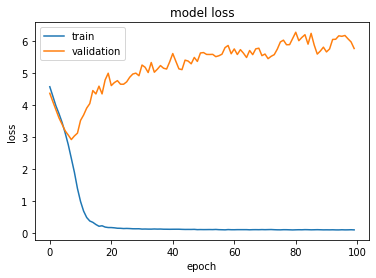

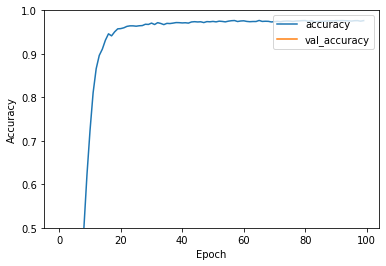

In [0]:
history=model.fit(train_data_gen,validation_data=valid_data_gen,epochs=100)
plotLosses(history)
plotAccuracies(history)
model.save(root_path+'final_model_segmented_1.h5')

In [0]:
#model.save(root_path+'final_model.h5')
scores = model.evaluate_generator(test_data_gen) 
print("Loss = ",scores[0],", Accuracy = ", scores[1])

  ...
    to  
  ['...']
Loss =  1.761272329550523 , Accuracy =  0.61538464


              precision    recall  f1-score   support

          98       0.06      0.06      0.06        16
          99       0.00      0.00      0.00        13
          93       0.00      0.00      0.00         9
          97       0.00      0.00      0.00        13
          96       0.00      0.00      0.00        18
          94       0.00      0.00      0.00        33
          90       0.00      0.00      0.00        17
          95       0.00      0.00      0.00        25
          92       0.00      0.00      0.00        13
          91       0.00      0.00      0.00        15
           9       0.00      0.00      0.00         9
          89       0.00      0.00      0.00        37
          85       0.12      0.08      0.10        13
          82       0.06      0.04      0.05        23
          83       0.06      0.04      0.05        26
          84       0.00      0.00      0.00        17
          88       0.03      0.03      0.03        31
          86       0.00    

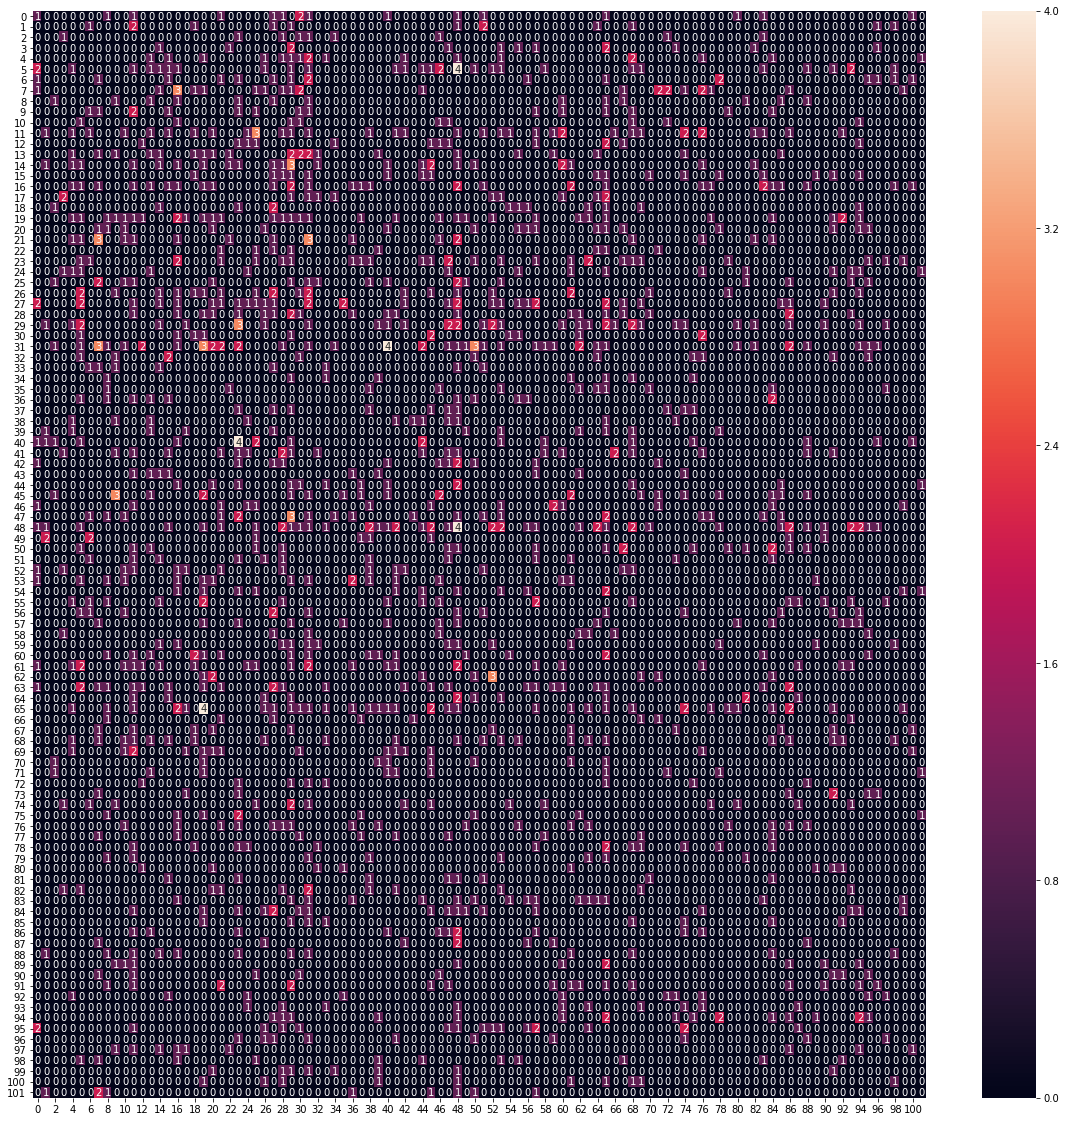

In [0]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from matplotlib import pyplot
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

import numpy as np
test_steps_per_epoch = np.math.ceil(test_data_gen.samples / test_data_gen.batch_size)

predictions = model.predict(test_data_gen, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data_gen.classes
class_labels = list(test_data_gen.class_indices.keys()) 

#print(class_labels)

report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

mat = confusion_matrix(true_classes,predicted_classes)
plt.figure(figsize=(20,20))
sns.heatmap(mat, annot=True, fmt="d");


In [0]:
import time
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras import optimizers


model = load_model(root_path+'small_cnn_4layers_HenormInit.h5')
sgd = optimizers.SGD(lr=0.0011, decay=1e-6, momentum=0.9, nesterov=True)

#Confusion Matrix and Classification Report
start = time.time()
test_steps_per_epoch = np.math.ceil(test_data_gen.samples / test_data_gen.batch_size)
predictions = model.predict_generator(test_data_gen, steps=test_steps_per_epoch)
# Get most likely class
predicted_class = np.argmax(predictions, axis=1)
end = time.time()

true_class = test_data_gen.classes
accuracy = accuracy_score(true_class, predicted_class)
print("accuracy : " ,accuracy)
print('Confusion Matrix')

mat = confusion_matrix(true_class, predicted_class)
plt.figure(figsize=(10,8))
sns.heatmap(mat, annot=True, fmt="d");
#print(mat)
# Show confusion matrix in a separate window

print('Classification Report')

print(classification_report(true_class, y_pred, target_names=CLASS_NAMES))


Instructions for updating:
Please use Model.predict, which supports generators.
